# Summarize population density maps (`.tif`) by shapefiles (`.shp`)

### What does this do

This notebook allows you to:
1. Load a `.tif` population density file and a `.shp` shapefile

2. Sum the values of the pixels in the density map inside each given shape, resulting in a table of shape attributes (e.g. admin level names) and the respective population

3. Save the resulting table in a `.csv` file

### How to run
1. Install Python and Jupyter (recommended distribution: the latest `miniconda`)

2. Use `pip` to install the following packages if not already installed:
    - `rasterstats`
    
    - `rioxarray`

    - `pandas`

    - `geopandas`
    
    - `matplotlib`


3. Download your chosen population density map and shapefile and set the data paths here correctly

4. Run the `Setup` and `Functions` section and the relevant country and/or copy a country example cell and modify it to match your density map and shapefile.

# Setup

In [1]:
from pathlib import Path
import os

import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
from rasterstats import zonal_stats

## NECESSARY FUNCTION TO EXTEND `zonal_stats` TO WORK WITH XARRAYS
def zonal_stats_extended(gdf, xds, prefix=None, stats="sum", output_type="dataframe"):
    """
    Extends rasterstarts' zonal_stats to easily input xarrays and output a Pandas DataFrame.

    Default operation is "sum".

    """
    raster = xds.to_numpy()[0]
    affine = xds.rio.transform()
    nodata_value = xds.rio.nodata

    zs = zonal_stats(
        gdf,
        raster,
        affine=affine,
        nodata=nodata_value,
        stats=stats,
        prefix=prefix,
    )

    if output_type == "dataframe":
        return pd.DataFrame(zs, index=gdf.index)
    else:
        return zs

In [3]:
# Set paths to data folders
path = Path.cwd()
data_path = path / "Data"
output_path = path / "Output_Data"

# Full run

## Functions

In [4]:
def load_tif(path):
    """load raster population density data (.tif) with np.nan as nodata value"""

    return rxr.open_rasterio(path, masked=True)

In [5]:

def load_and_sum_tif(tif_file_path, gdf, prefix=None, rounding=True):
    """Load a pop density map from file and create zonal sums using shapes from the given gdf."""

    xds = load_tif(tif_file_path)

    zonal_stats_df = zonal_stats_extended(
        gdf=gdf,
        xds=xds,
        prefix=prefix,
        stats="sum"
    )

    if rounding:
        zonal_stats_df = zonal_stats_df.round().fillna(0).astype(int)

    return zonal_stats_df

In [6]:
def load_and_sum_multiple_tifs(
    gdf,
    tif_folder_path=None,
    tif_file_paths=None,
    global_prefix=None, 
    file_prefix_list=None,
    rounding=True, 
    total_column=True
    ):
    """

    Primarily for WorldPop data since multiple files are provided, each for a different age/gender group.
    
    Load each density map file (either from a given folder or a list of file paths) and 
    get zonal sums of each based on a GeoDataFrame of shapes. Combine the results into 
    a single pandas dataframe and add a totals column if required.
    
    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame with shapes to summarize over.
    tif_folder_path : pathlib.Path, optional
        Path to folder with tif files to load. If provided, all tif files in the folder will be loaded and the 
        tif_file_paths parameter will be ignored.
    tif_file_paths : list, required if tif_folder_path is None
        List of paths to tif files.
    global_prefix : str, optional
        Prefix to add to all column names, by default None
    file_prefix_list : list, optional
        List of prefixes to add to each column name, by default None. If provided, must be the same length as the
        tif_file_paths list. If not provided, the file name will be used as the prefix.
    sum_rounding : bool, optional
        Whether to round sum values, by default True
    total_column : bool, optional
        Add a column with the total sum of all columns, by default True
        
    Returns
    -------
    pd.DataFrame
    
    """

    if tif_folder_path:
        tif_file_paths = list(tif_folder_path.glob("*.tif"))

    if not file_prefix_list:
        file_prefix_list = [f.stem for f in tif_file_paths]

    zonal_stats_df_list = []

    for tif_file_path, file_prefix in zip(tif_file_paths, file_prefix_list):
        prefix = global_prefix+file_prefix+"_"
        zonal_stats_df = load_and_sum_tif(tif_file_path, gdf, prefix, rounding)
        zonal_stats_df_list.append(zonal_stats_df)

    zonal_stats_df_all = pd.concat(zonal_stats_df_list, axis=1)


    if total_column:
        zonal_stats_df_all[global_prefix+"sum_total"] = zonal_stats_df_all.sum(axis=1)

    return zonal_stats_df_all

In [7]:
def combine_dataframes(
    gdf, 
    df_list, 
    shape_cols_to_keep, 
    save_csv, 
    output_csv_name="zonal_sums.csv"
    ):
    """Combine a list of dataframes with zonal sums with a GeoDataFrame of shapes and save result to file."""
    
    # combine all population dataframes
    pops_df = pd.concat(df_list, axis=1)

    # Combine with shape data
    gdf = gdf[shape_cols_to_keep+["geometry"]]
    combined_pops_gdf = pd.concat([gdf, pops_df], axis=1)

    # sort by area names
    combined_pops_gdf.sort_values(by=shape_cols_to_keep, inplace=True)

    ## save
    if save_csv:
        # save
        os.makedirs(output_path, exist_ok=True)
        combined_pops_gdf.drop(columns="geometry", axis=1).to_csv(output_path / output_csv_name, index=False,encoding  =  "utf-8" )

    return combined_pops_gdf

In [8]:
def df_w_latlons_to_gdf(
    df,
    lat_name = "Lat",
    lon_name = "Lon",
    crs="EPSG:4326",
):
    """
    Convert DataFrame to GeoDataFrame by creating geometries from lat-lon columns.

    Parameters
    ----------
    df : The DataFrame to convert.
    lat_name, lon_name : The names of the columns containing the latitude and longitude values.
        Default is 'Lat' and 'Lon'.
    crs : The coordinate reference system of the lat-lon columns.
    """
    latlon_point_geoms = gpd.points_from_xy(x=df[lon_name], y=df[lat_name])
    gdf = gpd.GeoDataFrame(df.copy(), geometry=latlon_point_geoms, crs=crs)
    return gdf

## Country Specific WorldPop/FB/LandScan summaries
(Summarising multiple `.tif` density files and combining the results)

### Malaria Consortium Countries

#### 1. Nigeria

In [59]:
nigeria_adm2_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "nga_adm_osgof_20190417_nigeria" / "nga_admbnda_adm2_osgof_20190417.shp")
nigeria_adm2_gdf.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,SD_EN,SD_PCODE,geometry
0,0.237074,0.001524,Aba North,NG001001,Aba North,NaN,NaN,Abia,NG001,Nigeria,NG,2016-11-29,2019-04-17,NaN,Abia South,NG00103,"POLYGON ((7.40111 5.08195, 7.40013 5.08237, 7...."
1,0.262477,0.003531,Aba South,NG001002,Aba South,NaN,NaN,Abia,NG001,Nigeria,NG,2016-11-29,2019-04-17,NaN,Abia South,NG00103,"POLYGON ((7.38749 5.08275, 7.38632 5.08236, 7...."
2,3.075316,0.326868,Abadam,NG008001,Abadam,NaN,NaN,Borno,NG008,Nigeria,NG,2016-11-29,2019-04-17,NaN,Borno North,NG00802,"POLYGON ((13.83477 13.42336, 13.81909 13.42175..."
3,2.537984,0.068379,Abaji,NG015001,Abaji,NaN,NaN,Federal Capital Territory,NG015,Nigeria,NG,2016-11-29,2019-04-17,NaN,Federal Capital Territory,NG01501,"POLYGON ((7.04587 9.23050, 7.02654 9.22216, 7...."
4,0.687150,0.014529,Abak,NG003001,Abak,NaN,NaN,Akwa Ibom,NG003,Nigeria,NG,2016-11-29,2019-04-17,NaN,Akwa Ibom North West,NG00302,"POLYGON ((7.81124 5.09453, 7.81233 5.09367, 7...."


##### Subset the data to only include required states

In [60]:
nigeria_mc_states=[ "Bauchi", "Borno", "Kebbi", "Kogi", "Nasarawa", "Plateau", "Sokoto"]

In [61]:
nigeria_adm2_gdf_mc_chosen_adm1 = nigeria_adm2_gdf[nigeria_adm2_gdf["ADM1_EN"].isin(nigeria_mc_states)]

In [62]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/"Nigeria"
worldpop_wopr_file_path= path/"Data"/ "WorldPop_WOPR" / "Nigeria" /"Data"/ "NGA_population_v2_0_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "nga_children_under_five_2020_geotiff_Nigeria" / "nga_children_under_five_2020.tif"
facebook_csv_file_path= path/"Data" / "Meta_HRSL" / "nga_children_under_five_2020_geotiff_Nigeria" / "nga_children_under_five_2020.csv"

In [63]:
# facebook_csv_df = pd.read_csv(facebook_csv_file_path)
# facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
# facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(nigeria_adm2_gdf_mc_chosen_adm1)
# facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="nga_children_under_five_2020", index=["ADM1_EN","ADM2_EN"], aggfunc=np.sum).reset_index()
# pivot_pop_df

In [64]:
# pivot_pop_df

In [65]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=nigeria_adm2_gdf_mc_chosen_adm1,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )

In [66]:
worldpop_cons_pops_df

,worldpop_cons_u5_nga_f_0_4_2021_1km_UNadj_constrained_Nigeria_sum,worldpop_cons_u5_nga_m_0_4_2021_1km_UNadj_constrained_Nigeria_sum,worldpop_cons_u5_sum_total
2,12219,11903,24122
12,21224,20675,41899
30,17818,17356,35174
45,13897,13537,27434
47,5185,5051,10236
...,...,...,...
754,15498,15097,30595
755,17285,16838,34123
760,6454,6287,12741
767,29806,29034,58840


In [67]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    nigeria_adm2_gdf_mc_chosen_adm1,
    prefix="worldpop_wopr_u5_",
    rounding=True
)



In [68]:
worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
2,20733
12,35143
30,20269
45,38298
47,17529
...,...
754,17070
755,10122
760,36091
767,54292


In [69]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    nigeria_adm2_gdf_mc_chosen_adm1,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
2,27300
12,48042
30,36646
45,27903
47,11601
...,...
754,35183
755,35326
760,13692
767,64291


##### Discounting for months not covered assuming growth is linear


In [70]:
worldpop_cons_pops_df["worldpop_cons_3-59_months"] = worldpop_cons_pops_df["worldpop_cons_u5_sum_total"] * (57/60)
worldpop_wopr_pops_df["worldpop_wopr_3-59_months"] = worldpop_wopr_pops_df["worldpop_wopr_u5_sum"] * (57/60)
facebook_pops_df["facebook_3-59_months"] = facebook_pops_df["facebook_u5_sum"] * (57/60)

* Discounting for months not covered using mortality rates

In [71]:
df_list = [worldpop_cons_pops_df, worldpop_wopr_pops_df,facebook_pops_df]


combined_pops_gdf = combine_dataframes(
    nigeria_adm2_gdf_mc_chosen_adm1, 
    df_list, 
    shape_cols_to_keep=["ADM1_EN","ADM2_EN"], 
    save_csv=True, 
    output_csv_name="mc_nigeria_output.csv"
    )

<Axes: >

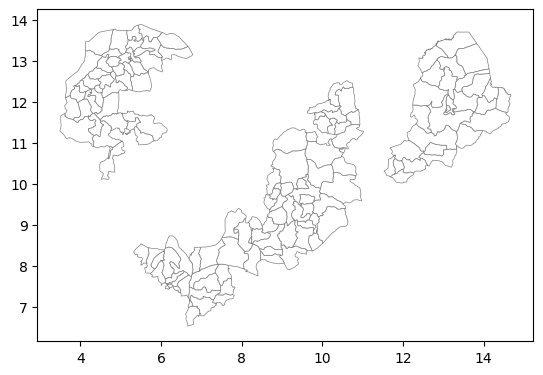

In [72]:
combined_pops_gdf.plot(color="white", edgecolor="gray", linewidth=0.5)

#### 2. Chad

In [9]:
chad_hd_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "tcd_a_hlt_districtssanitaires_msp_2020_Chad" / "tcd_a_hlt_districtsSanitaires_msp_2020.shp" )
chad_hd_gdf.head()

,SUPERFIC_1,CODEPS_1,CODEDS_1,District,Pcode,RegName,Pcode_DSR,Shape_Leng,Shape_Area,NAME_Distr,geometry
0,23552.10,15.0,1502.0,Am Timan,TDDS20191502,Salamat,TDDSR201915,7.832851,1.949268,AM TIMAN,"POLYGON Z ((20.15261 12.05673 0.00000, 20.2416..."
1,4762.85,11.0,1105.0,Moulkou,TDDS20191105,Mayo Kebbi Est,TDDSR201911,3.284327,0.347275,MOULKOU,"POLYGON Z ((15.04959 11.02029 0.00000, 15.0498..."
2,3129.61,9.0,904.0,Bessao,TDDS20190904,Logone Oriental,TDDSR201909,2.238116,0.257958,BESSAO,"POLYGON Z ((16.17274 8.29570 0.00000, 16.19130..."
3,3102.85,8.0,804.0,Moundou,TDDS20190804,Logone Occidental,TDDSR201908,2.880619,0.253470,MOUNDOU,"POLYGON Z ((16.37096 8.66562 0.00000, 16.39564..."
4,14765.50,13.0,1306.0,Kyabe,TDDS20191306,Moyen Chari,TDDSR201913,7.535757,1.216169,KYABE,"POLYGON Z ((18.35343 10.25059 0.00000, 18.3557..."


In [10]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Chad"
facebook_csv_file_path = path / "Data" / "Meta_HRSL" / "tcd_children_under_five_2020_geotiff_Chad" / "tcd_children_under_five_2020.csv"

# worldpop_wopr_file_path= Bottom-up estimates missing for Chad
# facebook_file_path= path/"Data" / "Meta_HRSL"  / "tcd_children_under_five_2020_geotiff_Chad"/ "tcd_children_under_five_2020.tif"

In [11]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=chad_hd_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )

worldpop_cons_pops_df

,worldpop_cons_u5_tcd_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_tcd_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,27045,26272,53317
1,11547,11217,22764
2,10759,10452,21211
3,39942,38800,78742
4,19836,19268,39104
...,...,...,...
121,16617,16142,32759
122,15191,14756,29947
123,6544,6357,12901
124,7170,6965,14135


In [12]:
facebook_csv_df = pd.read_csv(facebook_csv_file_path)
facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(chad_hd_gdf)
facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="tcd_children_under_five_2020", index=["District", "RegName"], aggfunc=np.sum).reset_index()


# facebook_pops_df

In [13]:
facebook_pops_df

,District,RegName,tcd_children_under_five_2020
0,9e Arrondissement,N'Djamena,41802.962255
1,Abdi,Ouaddai,33135.095590
2,Abeche,Ouaddai,81262.264047
3,Aboudeia,Salamat,17095.805218
4,Abougoudam,Ouaddai,19101.363908
...,...,...,...
121,Tissi,Sila,5035.680548
122,Torrock,Mayo Kebbi Ouest,8579.589284
123,Yao,Batha,36068.029965
124,Youe,Mayo Kebbi Est,5883.994225


##### Discounting for months not covered assuming growth is linear


In [14]:
worldpop_cons_pops_df["worldpop_cons_3-59_months"]=worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]*(57/60)
# worldpop_wopr_pops_df["worldpop_wopr_3-59_months"]=worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]*(57/60)
facebook_pops_df["facebook_3-59_months"]=facebook_pops_df["tcd_children_under_five_2020"]*(57/60)

##### Discounting for months not covered using mortality rates

In [24]:
df_list = [worldpop_cons_pops_df] # Missing worldpop_wopr_pops_df and 


combined_pops_gdf = combine_dataframes(
    chad_hd_gdf, 
    df_list, 
    shape_cols_to_keep=["District","RegName"], 
    save_csv=False, 
    output_csv_name=""
    )

In [26]:
# Merge `combined_df` and `facebook_pops_df` on the 'District' column
chad_merged_gdf = pd.merge(combined_pops_gdf,  facebook_pops_df, on=['District','RegName'], how='inner')
chad_merged_gdf


,District,RegName,geometry,worldpop_cons_u5_tcd_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_tcd_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total,worldpop_cons_3-59_months,tcd_children_under_five_2020,facebook_3-59_months
0,9e Arrondissement,N'Djamena,"POLYGON Z ((15.04869 12.08632 0.00000, 15.0528...",25241,24519,49760,47272.00,41802.962255,39712.814142
1,Abdi,Ouaddai,"POLYGON Z ((21.31058 13.16085 0.00000, 21.3273...",17831,17321,35152,33394.40,33135.095590,31478.340811
2,Abeche,Ouaddai,"POLYGON Z ((21.14912 14.03125 0.00000, 21.1803...",36934,35878,72812,69171.40,81262.264047,77199.150845
3,Aboudeia,Salamat,"POLYGON Z ((19.75100 12.05300 0.00000, 19.8532...",8153,7920,16073,15269.35,17095.805218,16241.014957
4,Abougoudam,Ouaddai,"POLYGON Z ((21.35229 13.25615 0.00000, 21.3970...",13362,12980,26342,25024.90,19101.363908,18146.295713
...,...,...,...,...,...,...,...,...,...
121,Tissi,Sila,"POLYGON Z ((22.55469 11.69413 0.00000, 22.5540...",10859,10549,21408,20337.60,5035.680548,4783.896521
122,Torrock,Mayo Kebbi Ouest,"POLYGON Z ((15.11450 9.59778 0.00000, 15.12211...",6469,6284,12753,12115.35,8579.589284,8150.609820
123,Yao,Batha,"POLYGON Z ((17.45000 13.49700 0.00000, 17.5330...",13673,13282,26955,25607.25,36068.029965,34264.628467
124,Youe,Mayo Kebbi Est,"POLYGON Z ((14.96475 9.71563 0.00000, 14.95533...",7750,7528,15278,14514.10,5883.994225,5589.794514


In [ ]:
# Export the merged dataframe to Excel
chad_merged_gdf.to_csv(path / "Output_Data"/ "mc_chad_output.csv")
chad_merged_gdf.plot(linewidth=0.5)


<Axes: >

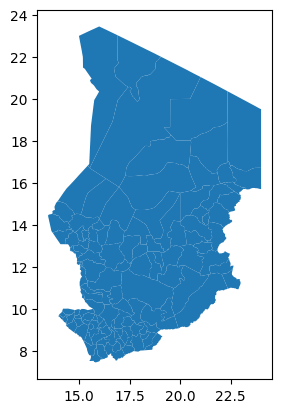

In [81]:
combined_pops_gdf.plot(linewidth=0.5)

#### 3. Burkina Faso

In [82]:
burkinafaso_hd_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Burkina Faso" / "Health Districts" / "bfa_dsa_igb_2020.shp")
burkinafaso_hd_gdf.head()

,NOMDEP,NOMPROVINC,NOMREGION,ADM0_PCODE,ADM1_PCODE,ADM2_PCODE,DS_PCODE,geometry
0,NONGR-MASSOUM,KADIOGO,CENTRE,BF,BF13,BF1300,BFDS130001,"POLYGON ((656658.950 1369716.628, 656945.700 1..."
1,BASKUY,KADIOGO,CENTRE,BF,BF13,BF1300,BFDS130002,"POLYGON ((658940.823 1364957.312, 658035.727 1..."
2,SIG-NONGHIN,KADIOGO,CENTRE,BF,BF13,BF1300,BFDS130003,"POLYGON ((655863.000 1394692.000, 655061.000 1..."
3,BOGODOGO,KADIOGO,CENTRE,BF,BF13,BF1300,BFDS130004,"POLYGON ((685050.000 1382403.000, 685711.000 1..."
4,BOULMIOUGOU,KADIOGO,CENTRE,BF,BF13,BF1300,BFDS130005,"POLYGON ((645803.000 1372070.000, 646566.242 1..."


In [83]:
burkinafaso_hd_gdf.crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
burkinafaso_hd_gdf_4326 = burkinafaso_hd_gdf.to_crs(4326)

In [85]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Burkina Faso"
worldpop_wopr_file_path= path/"Data"/ "WorldPop_WOPR" / "Burkina Faso" / "BFA_population_v1_1_agesex" / "BFA_population_v1_1_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "bfa_children_under_five_2020_geotiff_Burkina Faso"/ "bfa_children_under_five_2020.tif"

In [86]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=burkinafaso_hd_gdf_4326,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )

In [87]:
worldpop_cons_pops_df

,worldpop_cons_u5_bfa_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_bfa_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,57325,55442,112767
1,26933,26049,52982
2,41358,40000,81358
3,97608,94403,192011
4,116235,112417,228652
...,...,...,...
65,38633,37364,75997
66,16878,16324,33202
67,8707,8421,17128
68,47883,46311,94194


In [88]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    burkinafaso_hd_gdf_4326,
    prefix="worldpop_wopr_u5_",
    rounding=True
)



In [89]:
worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,72494
1,29028
2,63502
3,160590
4,162783
...,...
65,43783
66,26412
67,15994
68,89131


In [90]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    burkinafaso_hd_gdf_4326,
    prefix="facebook_u5_",
    rounding=True
)

In [91]:
# facebook_pops_df

##### Discounting for months not covered assuming growth is linear


In [92]:
worldpop_cons_pops_df["worldpop_cons_3-59_months"]=worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]*(57/60)
worldpop_wopr_pops_df["worldpop_wopr_3-59_months"]=worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]*(57/60)
facebook_pops_df["facebook_3-59_months"]=facebook_pops_df["facebook_u5_sum"]*(57/60)

##### Discounting for months not covered using mortality rates

In [93]:
df_list = [worldpop_cons_pops_df, worldpop_wopr_pops_df,facebook_pops_df]


combined_pops_gdf = combine_dataframes(
    burkinafaso_hd_gdf_4326, 
    df_list, 
    shape_cols_to_keep=["NOMDEP","NOMPROVINC"], 
    save_csv=True, 
    output_csv_name="mc_burkinafaso_output.csv"
    )

<Axes: >

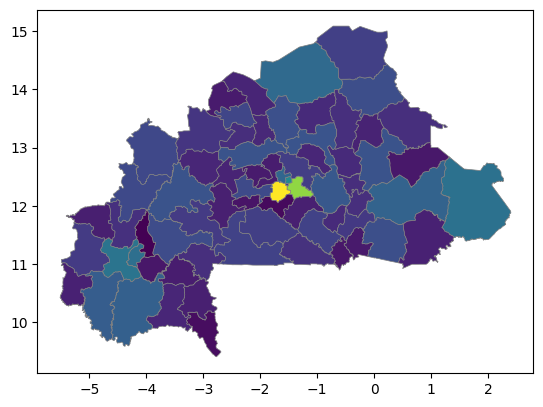

In [94]:
combined_pops_gdf.plot(column="worldpop_cons_3-59_months", edgecolor="gray", linewidth=0.5)

### HKI Countries

#### 1. Cameroon

In [95]:
cameroon_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Cameroon" / "cmr_admbnda_inc_20180104_SHP" / "cmr_admbnda_adm1_inc_20180104.shp" )
cameroon_admin1_gdf.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_FR,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1FR,ADM1ALT2FR,ADM0_EN,ADM0_FR,ADM0_PCODE,date,validOn,validTo,geometry
0,15.151424,5.235540,Adamawa,Adamaoua,CM001,NaN,NaN,NaN,NaN,NaN,Cameroon,Cameroun (le),CM,2018-12-17,2019-01-04,NaN,"POLYGON ((12.28874 8.18170, 12.28379 8.16514, ..."
1,16.170961,5.601567,Centre,Centre,CM002,NaN,NaN,NaN,NaN,NaN,Cameroon,Cameroun (le),CM,2018-12-17,2019-01-04,NaN,"POLYGON ((11.99753 6.26224, 11.99793 6.25936, ..."
2,18.826415,8.956520,East,Est,CM003,NaN,NaN,NaN,NaN,NaN,Cameroon,Cameroun (le),CM,2018-12-17,2019-01-04,NaN,"POLYGON ((14.39484 6.06262, 14.39542 6.06071, ..."
3,13.272860,2.826867,Far-North,Extrême-Nord,CM004,NaN,NaN,NaN,NaN,NaN,Cameroon,Cameroun (le),CM,2018-12-17,2019-01-04,NaN,"POLYGON ((14.53742 12.94356, 14.54344 12.93673..."
4,10.673468,1.646349,Littoral,Littoral,CM005,NaN,NaN,NaN,NaN,NaN,Cameroon,Cameroun (le),CM,2018-12-17,2019-01-04,NaN,"POLYGON ((9.84789 5.33234, 9.84934 5.32882, 9...."


In [96]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Cameroon"
# worldpop_wopr_file_path= path /  Missing for Cameroon
facebook_file_path= path/"Data" / "Meta_HRSL" / "cmr_children_under_five_2020_geotiff_Cameroon" / "cmr_children_under_five_2020.tif"

In [97]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=cameroon_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )

In [98]:
worldpop_cons_pops_df

,worldpop_cons_u5_cmr_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_cmr_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,115292,112938,228230
1,455707,446404,902111
2,85111,83374,168485
3,368902,361372,730274
4,354574,347336,701910
5,246272,241244,487516
6,185270,181488,366758
7,76032,74480,150512
8,151328,148239,299567
9,169945,166476,336421


In [99]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    cameroon_admin1_gdf,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
0,252860
1,849522
2,195168
3,879753
4,586270
5,597805
6,334796
7,161568
8,259754
9,338586


##### Discounting for months not covered assuming growth is linear


In [100]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]  =  worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]  *  (54/60)
facebook_pops_df["facebook_6-59_months"]  =  facebook_pops_df["facebook_u5_sum"]  *  (54/60)

##### Discounting for months not covered using mortality rates

In [101]:
df_list = [worldpop_cons_pops_df,facebook_pops_df] # Missing worldpop_wopr_pops_df


combined_pops_gdf = combine_dataframes(
    cameroon_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM1_EN",	"ADM1_FR"], 
    save_csv=True, 
    output_csv_name="hki_cameroon_output.csv"
    )

<Axes: >

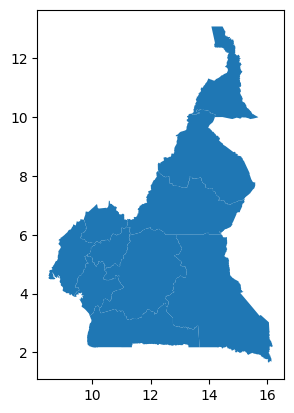

In [102]:
combined_pops_gdf.plot(linewidth=0.5)

#### 2. Cote'd'Ivoire

In [11]:
# cotedivoire_admin2_gdf = gpd.read_file(data_path / "Administrative Boundaries"/ "Cote'd'Ivoire" / "shapefiles" / "healthsites.shp")
# cotedivoire_admin2_gdf.to_excel("Health districts.xlsx")

In [9]:
cotedivoire_admin2_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Cote'd'Ivoire" / "civ_admbnda_adm2_cntig_ocha_itos_20180706.shp" )
cotedivoire_admin2_gdf.head()

,Shape_Leng,Shape_Area,ADM2_FR,ADM2_PCODE,ADM2_REF,ADM2ALT1FR,ADM2ALT2FR,ADM1_FR,ADM1_PCODE,ADM0_FR,ADM0_PCODE,date,validOn,ValidTo,geometry
0,3.260286,0.328283,Abengourou,CI2001,NaN,NaN,NaN,Indenie-Djuablin,CI20,Côte d'Ivoire,CI,2011-12-24,2018-07-06,NaN,"POLYGON ((-3.32144 7.03456, -3.32009 7.03382, ..."
1,2.324106,0.174570,Abidjan,CI0101,NaN,NaN,NaN,District Autonome D'Abidjan,CI01,Côte d'Ivoire,CI,2011-12-24,2018-07-06,NaN,"POLYGON ((-4.16993 5.60041, -4.16825 5.60020, ..."
2,3.728993,0.361297,Aboisso,CI3001,NaN,NaN,NaN,Sud-Comoe,CI30,Côte d'Ivoire,CI,2011-12-24,2018-07-06,NaN,"POLYGON ((-3.11099 6.15611, -3.08277 5.99869, ..."
3,1.389690,0.071538,Adiaké,CI3002,Adiake,NaN,NaN,Sud-Comoe,CI30,Côte d'Ivoire,CI,2011-12-24,2018-07-06,NaN,"POLYGON ((-3.18951 5.32363, -3.18497 5.31449, ..."
4,2.477939,0.167539,Adzopé,CI2401,Adzope,NaN,NaN,Me,CI24,Côte d'Ivoire,CI,2011-12-24,2018-07-06,NaN,"POLYGON ((-3.65078 6.44465, -3.64821 6.44352, ..."


In [10]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Cote'd'Ivoire" 
facebook_file_path= path/"Data" / "Meta_HRSL" / "civ_children_under_five_2020_geotiff_Cotedivoire"/ "civ_children_under_five_2020.tif" 
facebook_csv_file_path = path / "Data"/"Meta_HRSL"/"civ_children_under_five_2020_geotiff_Cotedivoire"/"civ_children_under_five_2020.csv"

In [11]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=cotedivoire_admin2_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_civ_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_civ_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,30414,29933,60347
1,443063,436056,879119
2,25280,24880,50160
3,6905,6795,13700
4,17578,17300,34878
...,...,...,...
103,8102,7974,16076
104,28580,28128,56708
105,18710,18415,37125
106,9835,9679,19514


In [12]:
# # Facebook
# facebook_pops_df = load_and_sum_tif(
#     facebook_file_path,
#     cotedivoire_admin2_gdf,
#     prefix="facebook_u5_",
#     rounding=True
# )
# facebook_pops_df

In [13]:
facebook_csv_df = pd.read_csv(facebook_csv_file_path)
facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(cotedivoire_admin2_gdf)
facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="civ_children_under_five_2020", index=["ADM2_FR"], aggfunc=np.sum).reset_index()


facebook_pops_df

,ADM2_FR,civ_children_under_five_2020
0,Abengourou,57365.908746
1,Abidjan,842925.342358
2,Aboisso,48149.914687
3,Adiaké,13375.807220
4,Adzopé,33495.397565
...,...,...
103,Yakassé-Attobrou,15279.808335
104,Yamoussoukro,54216.405866
105,Zouan-Hounien,35697.947974
106,Zoukougbeu,18680.153440


##### Discounting for months not covered assuming growth is linear


In [15]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]  =  worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]  *  (54/60)
facebook_pops_df["facebook_6-59_months"]  =  facebook_pops_df["civ_children_under_five_2020"]  * (54/60)

##### Discounting for months not covered using mortality rates

In [16]:
df_list = [worldpop_cons_pops_df] # Missing worldpop_wopr_pops_df while kernel crashes for facebook_pops_df 


combined_pops_gdf = combine_dataframes(
    cotedivoire_admin2_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM2_FR","ADM1_FR"], 
    save_csv=False, 
    output_csv_name="hki_cote_d'Ivoire_output.csv"
    )

<Axes: >

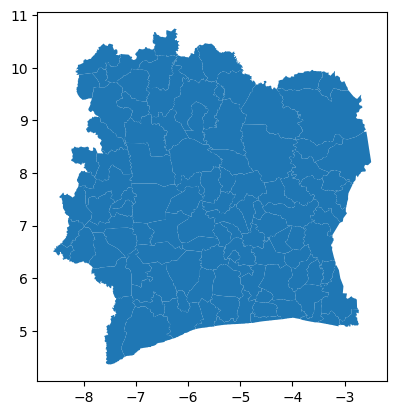

In [109]:
combined_pops_gdf.plot(linewidth=0.5)

<Axes: >

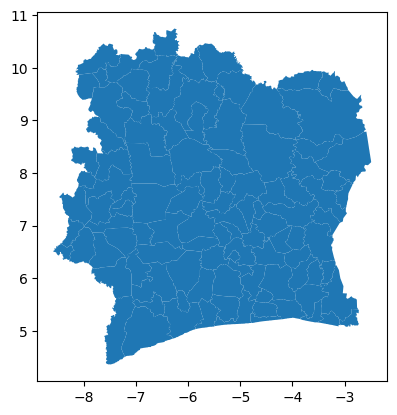

In [17]:
# Merge `combined_df` and `facebook_pops_df` on the 'District' column
cotedivoire_merged_gdf = pd.merge(combined_pops_gdf,  facebook_pops_df, on='ADM2_FR', how='inner')

# Export the merged dataframe to Excel
cotedivoire_merged_gdf.to_csv(path / "Output_Data"/ "hki_cote_d_ivoire_output.csv")
cotedivoire_merged_gdf.plot(linewidth=0.5)


#### 3. Democratic Republic of Congo

In [110]:
drc_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "DRC" / "cod_admbnda_adm1_rgc_itos_20190911.shp" )
drc_admin1_gdf.head()

,Shape_Leng,Shape_Area,ADM1_FR,ADM1_PCODE,ADM1_REF,ADM1ALT1FR,ADM1ALT2FR,ADM0_FR,ADM0_PCODE,date,validOn,validTo,geometry
0,24.837413,12.097933,Bas-Uele,CD52,NaN,NaN,NaN,République démocratique du Congo (la),CD,2019-09-09,2019-09-11,NaN,"POLYGON ((25.55505 5.37646, 25.56033 5.37533, ..."
1,20.947731,8.291592,Equateur,CD41,NaN,NaN,NaN,République démocratique du Congo (la),CD,2019-09-09,2019-09-11,NaN,"POLYGON ((19.51188 2.02196, 19.60032 2.00518, ..."
2,29.557091,10.316791,Haut-Katanga,CD71,NaN,NaN,NaN,République démocratique du Congo (la),CD,2019-09-09,2019-09-11,NaN,"POLYGON ((28.54810 -7.62268, 28.56232 -7.63546..."
3,20.855157,8.952551,Haut-Lomami,CD73,NaN,NaN,NaN,République démocratique du Congo (la),CD,2019-09-09,2019-09-11,NaN,"POLYGON ((25.94890 -6.23409, 25.94897 -6.24754..."
4,21.679976,7.433290,Haut-Uele,CD53,NaN,NaN,NaN,République démocratique du Congo (la),CD,2019-09-09,2019-09-11,NaN,"POLYGON ((27.39413 5.09610, 27.41456 5.08784, ..."


In [111]:

worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "DRC"
worldpop_wopr_file_path= path /  "Data" / "WorldPop_WOPR" / "DRC" / "COD_population_v3_0_agesex_under5.tif"
# facebook_file_path= path/"Data" / "Meta_HRSL" / "cod_children_under_five_2020_geotiff_DRC" / "cod_children_under_five_2020.tif"
facebook_csv_file_path = path / "Data" / "Meta_HRSL" / "cod_children_under_five_2020_geotiff_DRC" / "cod_children_under_five_2020.csv"


In [112]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=drc_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )

worldpop_cons_pops_df

,worldpop_cons_u5_cod_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_cod_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,121099,119901,241000
1,191777,189881,381658
2,851558,843136,1694694
3,638477,632162,1270639
4,169691,168013,337704
5,498602,493671,992273
6,503997,499012,1003009
7,577854,572139,1149993
8,454947,450447,905394
9,625264,619080,1244344


In [113]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    drc_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,0
1,0
2,677938
3,468906
4,2069
5,704099
6,462616
7,3509
8,326358
9,0


In [114]:
facebook_csv_df = pd.read_csv(facebook_csv_file_path)
facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(drc_admin1_gdf)
facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="cod_children_under_five_2020", index=["ADM1_FR"], aggfunc=np.sum).reset_index()


facebook_pops_df

,ADM1_FR,cod_children_under_five_2020
0,Bas-Uele,2.137569e+05
1,Equateur,3.450817e+05
2,Haut-Katanga,1.517221e+06
3,Haut-Lomami,1.123740e+06
4,Haut-Uele,2.984763e+05
5,Ituri,8.779015e+05
6,Kasaï,8.886901e+05
7,Kasaï-Central,1.016891e+06
8,Kasaï-Oriental,7.993290e+05
9,Kinshasa,1.100173e+06


In [115]:
# # Facebook
# facebook_pops_df = load_and_sum_tif(
#     facebook_file_path,
#     drc_admin1_gdf,
#     prefix="facebook_u5_",
#     rounding=True
# )

# facebook_pops_df

##### Discounting for months not covered assuming growth is linear

In [116]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]  =  worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]  *  (54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"]  =  worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]  *  (57/60)
facebook_pops_df["facebook_6-59_months"]  =  facebook_pops_df["cod_children_under_five_2020"]  *  (54/60)

##### Discounting for months not covered using mortality rates

In [117]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df] #kERNEL crash facebook_pops_df


combined_pops_gdf = combine_dataframes(
    drc_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM1_FR"], 
    save_csv=False, 
    # output_csv_name="hki_drc_output.csv"
    )

<Axes: >

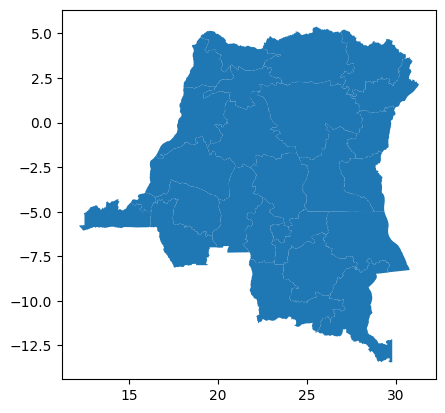

In [118]:
combined_pops_gdf.plot(linewidth=0.5)

<Axes: >

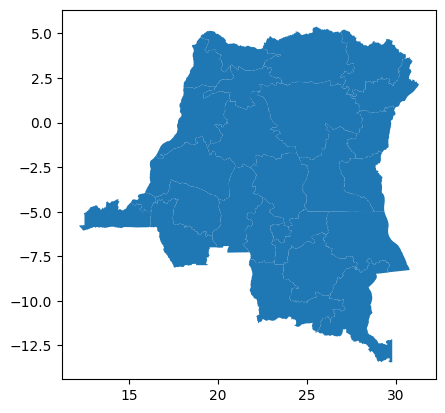

In [119]:
# Merge `combined_df` and `facebook_pops_df` on the 'District' column
drc_merged_gdf = pd.merge(combined_pops_gdf,  facebook_pops_df, on='ADM1_FR', how='inner')

# Export the merged dataframe to Excel
drc_merged_gdf.to_csv(path / "Output_Data"/ "hki_drc_output.csv")
drc_merged_gdf.plot(linewidth=0.5)


#### 4. Guinea

In [120]:
guinea_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Guinea"/ "gin_admbnda_adm1_ocha.shp" )
guinea_admin1_gdf.head()

,OBJECTID,admin1Name,admin1Pcod,admin1RefN,admin1AltN,admin1Al_1,admin0Name,admin0Pcod,date,validOn,validTo,Shape_Leng,Shape_Area,geometry
0,1,Boke,GN001,Boke,NaN,NaN,Guinea,GN,2016-01-14,2016-03-04,NaN,17.041947,2.834447,"MULTIPOLYGON (((-13.77147 9.84445, -13.78786 9..."
1,2,Conakry,GN002,Conakry,NaN,NaN,Guinea,GN,2016-01-14,2016-03-04,NaN,1.427320,0.035917,"MULTIPOLYGON (((-13.78686 9.46592, -13.78753 9..."
2,3,Faranah,GN003,Faranah,NaN,NaN,Guinea,GN,2016-01-14,2016-03-04,NaN,16.021557,2.948200,"POLYGON ((-10.33658 12.22495, -10.32740 12.219..."
3,4,Kankan,GN004,Kankan,NaN,NaN,Guinea,GN,2016-01-14,2016-03-04,NaN,16.948749,5.926705,"POLYGON ((-9.24517 12.49842, -9.23536 12.49558..."
4,5,Kindia,GN005,Kindia,NaN,NaN,Guinea,GN,2016-01-14,2016-03-04,NaN,11.543354,2.115180,"MULTIPOLYGON (((-13.32015 9.14776, -13.32569 9..."


In [121]:

worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Guinea"
worldpop_wopr_file_path= path /  "Data" / "WorldPop_WOPR" / "Guinea"/ "GIN_population_v1_0_agesex"/ "GIN_population_v1_0_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "gin_children_under_five_2020_geotiff_Guinea"/ "gin_children_under_five_2020.tif"

In [122]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=guinea_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_gin_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_gin_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,106702,103156,209858
1,164655,159182,323837
2,95038,91879,186917
3,218957,211679,430636
4,180406,174409,354815
5,93669,90556,184225
6,67738,65486,133224
7,148197,143272,291469


In [123]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    guinea_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,207375
1,236372
2,189896
3,468403
4,309430
5,189278
6,137631
7,292823


In [124]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    guinea_admin1_gdf,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
0,231450
1,352411
2,205921
3,475634
4,396068
5,202602
6,146444
7,323272


##### Discounting for months not covered assuming growth is linear

In [125]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]  =  worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]  *  (54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"]  =  worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]  *  (54/60)
facebook_pops_df["facebook_6-59_months"]  =  facebook_pops_df["facebook_u5_sum"]  *  (54/60)

##### Discounting for months not covered using mortality rates

In [126]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df,facebook_pops_df] 


combined_pops_gdf = combine_dataframes(
    guinea_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["admin1Name"], 
    save_csv=True, 
    output_csv_name="hki_guinea_output.csv"
    )

<Axes: >

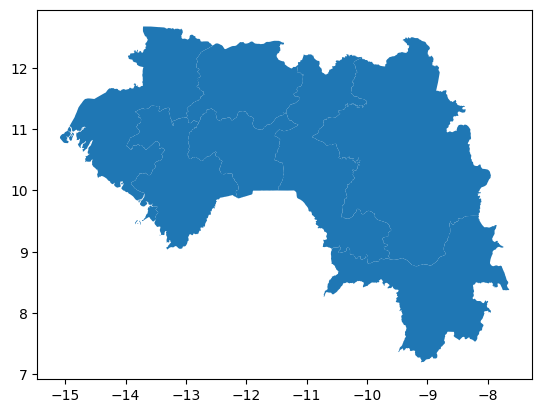

In [127]:
combined_pops_gdf.plot(linewidth=0.5)

#### 5. Kenya

In [9]:
kenya_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Kenya"/ "ken_admbnda_adm1_iebc_20191031.shp" )
kenya_admin1_gdf.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,5.932315,0.884732,Baringo,KE030,NaN,NaN,NaN,Kenya,KE,2017-11-03,2019-10-31,NaN,"POLYGON ((35.78390 1.65557, 35.78496 1.65554, ..."
1,2.922220,0.198099,Bomet,KE036,NaN,NaN,NaN,Kenya,KE,2017-11-03,2019-10-31,NaN,"POLYGON ((35.47360 -0.39920, 35.47845 -0.40663..."
2,3.062486,0.245058,Bungoma,KE039,NaN,NaN,NaN,Kenya,KE,2017-11-03,2019-10-31,NaN,"POLYGON ((34.62017 1.10228, 34.62133 1.10160, ..."
3,2.670396,0.147178,Busia,KE040,NaN,NaN,NaN,Kenya,KE,2017-11-03,2019-10-31,NaN,"POLYGON ((34.36097 0.77730, 34.36172 0.77696, ..."
4,3.888933,0.244432,Elgeyo-Marakwet,KE028,NaN,NaN,NaN,Kenya,KE,2017-11-03,2019-10-31,NaN,"POLYGON ((35.69818 1.28225, 35.69788 1.27905, ..."


In [10]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Kenya"
worldpop_wopr_file_path= path /  "Data" / "WorldPop_WOPR" / "Kenya"/ "KEN_populationv1_0_agesex"/ "KEN_population_v1_0_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "ken_children_under_five_2020_geotiff_Kenya"/ "ken_children_under_five_2020.tif"

In [11]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=kenya_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_ken_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_ken_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,51210,50524,101734
1,69331,68403,137734
2,114581,113047,227628
3,62040,61209,123249
4,35217,34745,69962
5,41380,40826,82206
6,98841,97518,196359
7,76787,75759,152546
8,12242,12078,24320
9,63209,62363,125572


In [12]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    kenya_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,54049
1,64105
2,126074
3,65403
4,34249
5,35138
6,76280
7,87658
8,25415
9,93676


In [14]:

# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    kenya_admin1_gdf,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
0,130223
1,172412
2,340627
3,177669
4,90235
5,121541
6,169324
7,213971
8,56221
9,210258


##### Discounting for months not covered assuming growth is linear

In [15]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]=worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]*(54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"]=worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]*(54/60)
facebook_pops_df["facebook_6-59_months"]=facebook_pops_df["facebook_u5_sum"]*(54/60)

##### Discounting for months not covered using mortality rates

In [16]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df,facebook_pops_df] 


combined_pops_gdf = combine_dataframes(
    kenya_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM1_EN"], 
    save_csv=True, 
    output_csv_name="hki_kenya_output.csv"
    )

<Axes: >

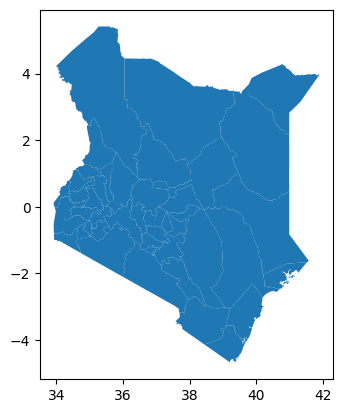

In [135]:
combined_pops_gdf.plot(linewidth=0.5)

#### 6. Mali

In [136]:
mali_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Mali"/ "mli_admbnda_adm1_1m_gov_20211220.shp" )
mali_admin1_gdf.head()

,Shape_Leng,Shape_Area,ADM1_FR,ADM1_PCODE,ADM1_REF,ADM1ALT1FR,ADM1ALT2FR,ADM0_FR,ADM0_PCODE,date,validOn,validTo,geometry
0,20.449044,10.250256,Kayes,ML01,NaN,NaN,NaN,Mali (le),ML,2015-06-01,2021-12-20,NaN,"POLYGON ((-9.33008 15.49779, -9.32934 15.49680..."
1,21.764713,7.563718,Koulikoro,ML02,NaN,NaN,NaN,Mali (le),ML,2015-06-01,2021-12-20,NaN,"POLYGON ((-9.00038 15.49748, -8.98331 15.49567..."
2,20.958431,5.965027,Sikasso,ML03,NaN,NaN,NaN,Mali (le),ML,2015-06-01,2021-12-20,NaN,"POLYGON ((-5.11493 12.65576, -5.10873 12.62608..."
3,14.430528,5.158060,Ségou,ML04,Segou,NaN,NaN,Mali (le),ML,2015-06-01,2021-12-20,NaN,"POLYGON ((-5.33016 15.49615, -5.31408 15.49470..."
4,16.266328,6.649725,Mopti,ML05,NaN,NaN,NaN,Mali (le),ML,2015-06-01,2021-12-20,NaN,"POLYGON ((-3.23658 15.85735, -3.23052 15.85703..."


In [137]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Mali"
worldpop_wopr_file_path= path /  "Data" / "WorldPop_WOPR" / "Mali"/ "MLI_population_v1_0_agesex/MLI_population_v1_0_agesex_under5.tif"
facebook_csv_file_path = path / "Data" / "Meta_HRSL" / "mli_children_under_five_2020_geotiff_Mali" / "mli_children_under_five_2020.csv"
# facebook_file_path= path/"Data" / "Meta_HRSL" / "mli_children_under_five_2020_geotiff_Mali"/ "mli_children_under_five_2020.tif"

In [138]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=mali_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_mli_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_mli_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,264223,258252,522475
1,408579,399347,807926
2,362575,354382,716957
3,299269,292507,591776
4,256930,251125,508055
5,98026,95811,193837
6,74516,72832,147348
7,12580,12296,24876
8,286076,279613,565689
9,7694,7520,15214


In [139]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    mali_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,570560
1,894384
2,717957
3,689670
4,632888
5,195439
6,147196
7,11393
8,464306
9,17196


In [140]:
facebook_csv_df = pd.read_csv(facebook_csv_file_path)
facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(mali_admin1_gdf)
facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="mli_children_under_five_2020", index=["ADM1_FR"], aggfunc=np.sum).reset_index()


facebook_pops_df

,ADM1_FR,mli_children_under_five_2020
0,Bamako,429775.046345
1,Gao,136147.347021
2,Kayes,504231.719318
3,Kidal,20339.338018
4,Koulikoro,726177.120770
5,Menaka,13525.476048
6,Mopti,463923.530391
7,Sikasso,697597.584364
8,Ségou,548203.473807
9,Tombouctou,175890.362845


In [141]:
# # Facebook
# facebook_pops_df = load_and_sum_tif(
#     facebook_file_path,
#     mali_admin1_gdf,
#     prefix="facebook_u5_",
#     rounding=True
# )
# facebook_pops_df

##### Discounting for months not covered assuming growth is linear

In [142]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]=worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]*(54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"]=worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]*(57/60)
facebook_pops_df["facebook_6-59_months"]=facebook_pops_df["mli_children_under_five_2020"]*(54/60)

##### Discounting for months not covered using mortality rates

In [143]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df] # Kernel crash on facebook_pops_df


combined_pops_gdf = combine_dataframes(
    mali_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM1_FR"], 
    save_csv=False, 
    output_csv_name="hki_mali_output.csv"
    )

<Axes: >

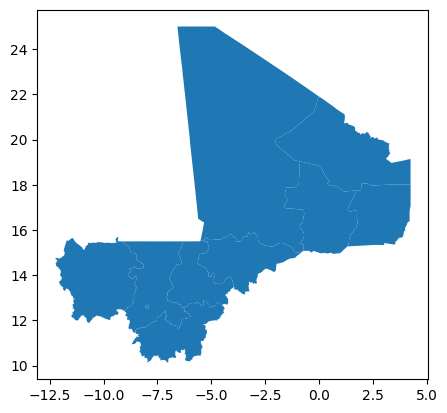

In [144]:
combined_pops_gdf.plot(linewidth=0.5)

<Axes: >

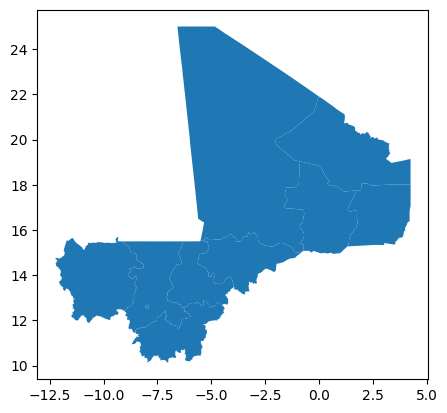

In [145]:
# Merge `combined_df` and `facebook_pops_df` on the 'District' column
mali_merged_gdf = pd.merge(combined_pops_gdf,  facebook_pops_df, on='ADM1_FR', how='inner')

# Export the merged dataframe to Excel
mali_merged_gdf.to_csv(path / "Output_Data"/ "hki_mali_output.csv")
mali_merged_gdf.plot(linewidth=0.5)


#### 7. Niger

In [146]:
niger_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "Niger"/ "NER_adm01_feb2018.shp" )
niger_admin1_gdf.head()

,OBJECTID,adm_01,Shape_Leng,Shape_Area,rowcacode1,NOMREG,ISO3,ISO2,geometry
0,1,Agadez,32.960455,53.547633,NER001,AGADEZ,NER,NE,"POLYGON ((11.98901 23.53319, 11.99796 23.51602..."
1,2,Diffa,18.408306,12.306259,NER002,DIFFA,NER,NE,"POLYGON ((15.55942 18.00625, 15.55675 17.95649..."
2,3,Dosso,8.965807,2.617021,NER003,DOSSO,NER,NE,"POLYGON ((3.66840 11.98401, 3.66388 11.98413, ..."
3,4,Maradi,8.531121,3.293766,NER004,MARADI,NER,NE,"POLYGON ((7.76947 14.42108, 7.82971 14.41669, ..."
4,5,Niamey,1.068639,0.046497,NER008,NIAMEY,NER,NE,"POLYGON ((2.09448 13.61969, 2.09711 13.61829, ..."


In [147]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/ "Niger"
worldpop_wopr_file_path= path /  "Data" / "WorldPop_WOPR" / "Niger"/"NER_population_v1_0_agesex"/ "NER_population_v1_0_agesex_under5.tif"
facebook_csv_file_path = path / "Data" / "Meta_HRSL" / "ner_children_under_five_2020_geotiff_Niger" / "ner_children_under_five_2020.csv"
# facebook_file_path= path/"Data" / "Meta_HRSL" / "ner_children_under_five_2020_geotiff_Niger"/ "ner_children_under_five_2020.tif"

In [148]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=niger_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_ner_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_ner_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,70584,72906,143490
1,94292,97394,191686
2,270945,279858,550803
3,490176,506300,996476
4,141960,146630,288590
5,529446,546863,1076309
6,381942,394506,776448
7,550566,568677,1119243


In [149]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    niger_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,113887
1,156003
2,544313
3,1080606
4,212294
5,936037
6,737947
7,1067443


In [150]:
# # Facebook
# facebook_pops_df = load_and_sum_tif(
#     facebook_file_path,
#     niger_admin1_gdf,
#     prefix="facebook_u5_",
#     rounding=True
# )
# facebook_pops_df

In [151]:
facebook_csv_df = pd.read_csv(facebook_csv_file_path)
facebook_csv_gdf = df_w_latlons_to_gdf(facebook_csv_df, lat_name = "latitude", lon_name = "longitude")  
facebook_csv_gdf_w_adm = facebook_csv_gdf.sjoin(niger_admin1_gdf)
facebook_pops_df = facebook_csv_gdf_w_adm.pivot_table(values="ner_children_under_five_2020", index=["adm_01"], aggfunc=np.sum).reset_index()


facebook_pops_df

,adm_01,ner_children_under_five_2020
0,Agadez,1.272814e+05
1,Diffa,1.901520e+05
2,Dosso,5.286057e+05
3,Maradi,1.066943e+06
4,Niamey,2.301063e+05
5,Tahoua,1.093356e+06
6,Tillabéri,7.455088e+05
7,Zinder,1.186336e+06


##### Discounting for months not covered assuming growth is linear

In [152]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"]=worldpop_cons_pops_df["worldpop_cons_u5_sum_total"]*(54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"]=worldpop_wopr_pops_df["worldpop_wopr_u5_sum"]*(57/60)
facebook_pops_df["facebook_6-59_months"]=facebook_pops_df["ner_children_under_five_2020"]*(54/60)

##### Discounting for months not covered using mortality rates

In [153]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df] # Kernel crash on facebook_pops_df


combined_pops_gdf = combine_dataframes(
    niger_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["adm_01"], 
    save_csv=False, 
    output_csv_name="hki_niger_output.csv"
    )


<Axes: >

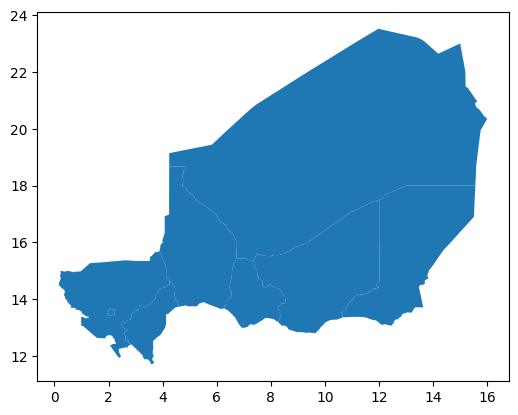

In [154]:
combined_pops_gdf.plot(linewidth=0.5)

<Axes: >

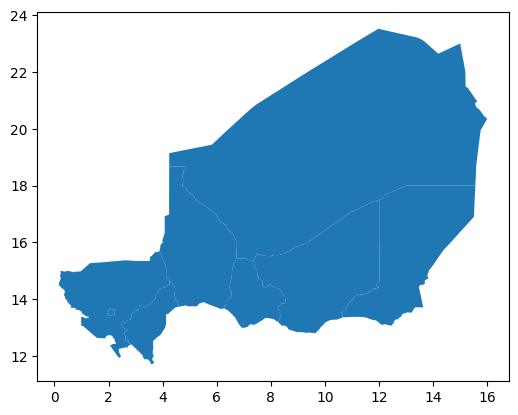

In [155]:
# Merge `combined_df` and `facebook_pops_df` on the 'District' column
niger_merged_gdf = pd.merge(combined_pops_gdf,  facebook_pops_df, on='adm_01', how='inner')

# Export the merged dataframe to Excel
niger_merged_gdf.to_csv(path / "Output_Data"/ "hki_niger_output.csv")
niger_merged_gdf.plot(linewidth=0.5)


#### 8. Nigeria

In [156]:
nigeria_admin1_gdf = gpd.read_file(data_path / "Administrative Boundaries" / "nga_adm_osgof_20190417_nigeria"/ "nga_admbnda_adm1_osgof_20190417.shp" )
nigeria_admin1_gdf.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,4.695135,0.396543,Abia,NG001,Abia,NaN,NaN,Nigeria,NG,2016-11-29,2019-04-17,NaN,"POLYGON ((7.38681 6.03667, 7.38729 6.03605, 7...."
1,11.525443,3.113007,Adamawa,NG002,Adamawa,NaN,NaN,Nigeria,NG,2016-11-29,2019-04-17,NaN,"POLYGON ((13.62129 10.94823, 13.62592 10.94822..."
2,5.263830,0.549476,Akwa Ibom,NG003,Akwa Ibom,NaN,NaN,Nigeria,NG,2016-11-29,2019-04-17,NaN,"MULTIPOLYGON (((8.34482 4.61140, 8.34496 4.609..."
3,3.595960,0.392661,Anambra,NG004,Anambra,NaN,NaN,Nigeria,NG,2016-11-29,2019-04-17,NaN,"POLYGON ((6.93254 6.71090, 6.93167 6.69870, 6...."
4,13.952005,4.011018,Bauchi,NG005,Bauchi,NaN,NaN,Nigeria,NG,2016-11-29,2019-04-17,NaN,"POLYGON ((10.75125 12.46148, 10.75615 12.39191..."


In [157]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/"Nigeria"
worldpop_wopr_file_path= path/"Data"/ "WorldPop_WOPR" / "Nigeria" /"Data"/ "NGA_population_v2_0_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "nga_children_under_five_2020_geotiff_Nigeria" / "nga_children_under_five_2020.tif"

In [158]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=nigeria_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_nga_f_0_4_2021_1km_UNadj_constrained_Nigeria_sum,worldpop_cons_u5_nga_m_0_4_2021_1km_UNadj_constrained_Nigeria_sum,worldpop_cons_u5_sum_total
0,342079,333225,675304
1,403581,393136,796717
2,508128,494977,1003105
3,489636,476964,966600
4,595045,579645,1174690
5,211898,206414,418312
6,522959,509424,1032383
7,536336,522455,1058791
8,313286,305177,618463
9,516472,503105,1019577


In [159]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    nigeria_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,395110
1,887359
2,395105
3,566255
4,1664629
5,131802
6,1864954
7,1130981
8,263612
9,505036


In [160]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    nigeria_admin1_gdf,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
0,461286
1,850174
2,730008
3,643525
4,1380317
5,309272
6,1131589
7,1202513
8,477778
9,769238


##### Discounting for months not covered assuming growth is linear

In [161]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"] = worldpop_cons_pops_df["worldpop_cons_u5_sum_total"] * (54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"] = worldpop_wopr_pops_df["worldpop_wopr_u5_sum"] * (57/60)
facebook_pops_df["facebook_6-59_months"] = facebook_pops_df["facebook_u5_sum"] * (54/60)

##### Discounting for months not covered using mortality rates

In [162]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df,facebook_pops_df]


combined_pops_gdf = combine_dataframes(
    nigeria_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM1_EN"], 
    save_csv=True, 
    output_csv_name="hki_nigeria_output.csv"
    )


<Axes: >

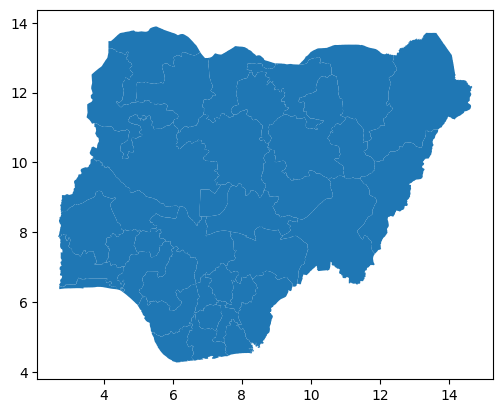

In [163]:
combined_pops_gdf.plot(linewidth=0.5)

#### 9. Burkina Faso

In [164]:
burkinafaso_admin1_gdf = gpd.read_file(data_path /  "Administrative Boundaries" / "Burkina Faso" / "bfa_admbnda_adm1_igb_20200323.shp" )
burkinafaso_admin1_gdf.head()

,Shape_Leng,Shape_Area,ADM1_FR,ADM1_PCODE,ADM1_REF,ADM1ALT1FR,ADM1ALT2FR,ADM0_FR,ADM0_PCODE,date,validOn,validTo,geometry
0,12.979104,2.866733,Boucle du Mouhoun,BF46,NaN,NaN,NaN,Burkina Faso,BF,2020-03-18,2020-03-23,NaN,"POLYGON ((-3.18158 13.67744, -3.18109 13.67721..."
1,9.431868,1.509470,Cascades,BF47,NaN,NaN,NaN,Burkina Faso,BF,2020-03-18,2020-03-23,NaN,"POLYGON ((-5.38923 11.00086, -5.37382 10.97698..."
2,3.287168,0.248302,Centre,BF13,NaN,NaN,NaN,Burkina Faso,BF,2020-03-18,2020-03-23,NaN,"POLYGON ((-1.60508 12.67250, -1.58739 12.67057..."
3,8.425414,1.201324,Centre-Est,BF48,NaN,NaN,NaN,Burkina Faso,BF,2020-03-18,2020-03-23,NaN,"POLYGON ((-0.30646 12.55612, -0.30573 12.55588..."
4,7.905622,1.646603,Centre-Nord,BF49,NaN,NaN,NaN,Burkina Faso,BF,2020-03-18,2020-03-23,NaN,"MULTIPOLYGON (((-0.76975 12.55062, -0.77002 12..."


In [165]:
worldpop_cons_folder_path= path / "Data" / "WorldPop_Constrained_1km_UNadj"/"Burkina Faso"
worldpop_wopr_file_path= path/"Data"/ "WorldPop_WOPR" / "Burkina Faso" / "BFA_population_v1_1_agesex" / "BFA_population_v1_1_agesex_under5.tif"
facebook_file_path= path/"Data" / "Meta_HRSL" / "bfa_children_under_five_2020_geotiff_Burkina Faso" / "bfa_children_under_five_2020.tif"

In [166]:
# WorldPop Constrained
worldpop_cons_pops_df = load_and_sum_multiple_tifs(
    gdf=burkinafaso_admin1_gdf,
    tif_folder_path=worldpop_cons_folder_path,
    global_prefix="worldpop_cons_u5_", 
    rounding=True, 
    total_column=True
    )
worldpop_cons_pops_df

,worldpop_cons_u5_bfa_f_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_bfa_m_0_4_2022_1km_UNadj_constrained_sum,worldpop_cons_u5_sum_total
0,155894,150774,306668
1,91047,88057,179104
2,340002,328837,668839
3,136239,131765,268004
4,140212,135608,275820
5,137553,133035,270588
6,71235,68895,140130
7,163718,158342,322060
8,198771,192243,391014
9,128313,124099,252412


In [167]:
# WorldPop Bottom-up estimates
worldpop_wopr_pops_df = load_and_sum_tif(
    worldpop_wopr_file_path,
    burkinafaso_admin1_gdf,
    prefix="worldpop_wopr_u5_",
    rounding=True
)


worldpop_wopr_pops_df

,worldpop_wopr_u5_sum
0,307749
1,131510
2,490513
3,255829
4,303443
5,268718
6,127668
7,314472
8,362552
9,278750


In [168]:
# Facebook
facebook_pops_df = load_and_sum_tif(
    facebook_file_path,
    burkinafaso_admin1_gdf,
    prefix="facebook_u5_",
    rounding=True
)
facebook_pops_df

,facebook_u5_sum
0,323142
1,183375
2,505661
3,286884
4,299022
5,273554
6,138916
7,386277
8,382311
9,261891


##### Discounting for months not covered assuming growth is linear

In [169]:
worldpop_cons_pops_df["worldpop_cons_6-59_months"] = worldpop_cons_pops_df["worldpop_cons_u5_sum_total"] * (54/60)
worldpop_wopr_pops_df["worldpop_wopr_6-59_months"] = worldpop_wopr_pops_df["worldpop_wopr_u5_sum"] * (57/60)
facebook_pops_df["facebook_6-59_months"] = facebook_pops_df["facebook_u5_sum"] * (54/60)

##### Discounting for months not covered using mortality rates

In [170]:
df_list = [worldpop_cons_pops_df,worldpop_wopr_pops_df,facebook_pops_df]


combined_pops_gdf = combine_dataframes(
    burkinafaso_admin1_gdf, 
    df_list, 
    shape_cols_to_keep=["ADM1_FR"], 
    save_csv=True, 
    output_csv_name="hki_burkina_faso_output.csv"
    )


<Axes: >

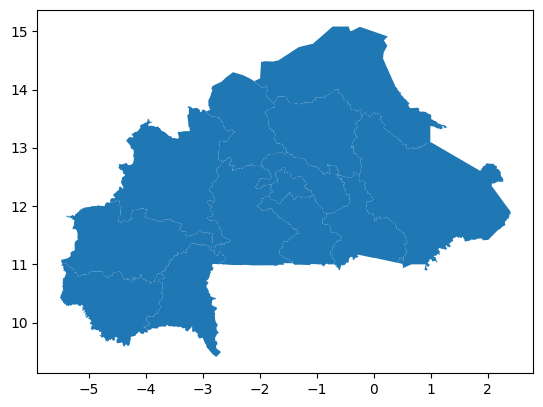

In [171]:
combined_pops_gdf.plot(linewidth=0.5)